# Lab 2 Sample Code

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

In [73]:
def sigmoid(x):
    """Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def der_sigmoid(dA, Z):
    """First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    A = sigmoid(Z)
    dZ = dA * A * (1 - A)
    return dZ

def der_relu(dA, Z):
    A = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))
    return dZ


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, (x > y).astype(np.int64).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_chessboard(n=100):
        """Data generation (Chessboard)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64).reshape(
            (-1, 1)
        )

    @staticmethod
    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR" or mode == "Chessboard"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor, "Chessboard": GenData._gen_chessboard}[mode]

        return data_gen_func(n)


class SimpleNet:
    def __init__(self, num_step=6000, print_interval=100, learning_rate=1e-2):  # don't change print_interval
        """A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        
        self.num_step = num_step
        self.print_interval = print_interval
        self.learning_rate = learning_rate
                                                
        self.nn_architecture = [
            {"input_ch": 2, "output_ch": 100, "activation": "relu"},
            {"input_ch": 100, "output_ch": 50, "activation": "relu"},
            {"input_ch": 50, "output_ch": 10, "activation": "relu"},
            {"input_ch": 10, "output_ch": 1, "activation": "sigmoid"}
        ]

    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[1] == gt_y.shape[1] == pred_y.shape[1], f"{data.shape}, {gt_y.shape}, {pred_y.shape}"

        plt.figure(figsize=(11, 5))

        plt.subplot(121)
        plt.title("Ground Truth", fontsize=18)
        plt.scatter(data[0,:], data[1,:], c=gt_y[0,:], cmap=plt.cm.bwr)

        plt.subplot(122)
        plt.title("Prediction", fontsize=18)
        plt.scatter(data[0,:], data[1,:], c=pred_y[0,:], cmap=plt.cm.bwr)

        plt.show()

    def initialize_parameters(self, nn_architecture):
        np.random.seed(1)
        parameters = {}       

        for idx, layer in enumerate(nn_architecture):
            layer_idx = idx + 1
            parameters['wei' + str(layer_idx)] = np.random.randn(
                layer["output_ch"], layer["input_ch"]) * 0.1
            parameters['bias' + str(layer_idx)] = np.random.randn(
                layer["output_ch"], 1) * 0.1
        
        return parameters

    def one_layer_forward_propagation(self, A_prev, wei, bias, activation_fn):
        if activation_fn == "sigmoid":
             activation = sigmoid
        elif activation_fn == "relu":
             activation = relu

        Z = np.dot(wei, A_prev) + bias
        A = activation(Z)

        cache = (A_prev, wei, bias, Z)

        return A, cache

    def forward(self, input, parameters):
        A = input
        caches = []                       

        for index, layer in enumerate(self.nn_architecture):
            layer_idx = index + 1
            A_prev = A
            A, cache = self.one_layer_forward_propagation(
                A_prev, parameters["wei"+str(layer_idx)], \
                parameters["bias"+str(layer_idx)], layer["activation"])
            caches.append(cache)

        return A, caches

    def one_layer_backward_propagation(self, dA, cache, activation_fn):
        A_prev, wei, bias, Z = cache

        if activation_fn == "sigmoid":
            activation_gra = der_sigmoid
        elif activation_fn == "relu":
            activation_gra = der_relu
                    
        dZ = activation_gra(dA, Z)
        m = A_prev.shape[1]

        dwei = (1 / m) * np.dot(dZ, A_prev.T)
        dbias = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(wei.T, dZ)
        
        return dA_prev, dwei, dbias


    def backward(self, predict, label, caches, parameters):
        label = label.reshape(predict.shape)
        gradients = {}
        numerator = predict - label
        denominator = np.clip(np.multiply(predict, 1 - predict), 10**-7, None)
        dacti_prev = np.divide(numerator, denominator)

        for idx, layer in reversed(list(enumerate(self.nn_architecture))):
            layer_idx = idx + 1
            dacti_curr = dacti_prev
            dacti_prev, dwei, dbias = self.one_layer_backward_propagation(
                dacti_curr, caches[idx], layer["activation"])
            gradients["dacti"+str(layer_idx)] = dacti_prev
            gradients["dwei"+str(layer_idx)] = dwei
            gradients["dbias"+str(layer_idx)] = dbias

        self.update_parameters(parameters, gradients, self.learning_rate, self.nn_architecture)

    def criterion(self, predict, label):
        m = label.shape[1]
        predict = np.clip(predict, 10**-7, 1 - 10**-7)
        loss = -1 / m * (np.dot(label, np.log(predict).T) + np.dot(1 - label, np.log(1 - predict).T))
        return np.squeeze(loss)

    def update_parameters(self, parameters, gradients, learning_rate, nn_architecture):
        for idx, layer in enumerate(nn_architecture):
            layer_idx = idx + 1
            parameters["wei" + str(layer_idx)] = parameters[
                "wei" + str(layer_idx)] - learning_rate * gradients["dwei" + str(layer_idx)]
            parameters["bias" + str(layer_idx)] = parameters[
                "bias" + str(layer_idx)] - learning_rate * gradients["dbias" + str(layer_idx)]
        return parameters

    def train(self, inputs, labels, batch_size = 1):
        """The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to inputs data.
        """
        assert inputs.shape[1] == labels.shape[1]
        n = int(inputs.shape[1]/batch_size)

        parameters = self.initialize_parameters(self.nn_architecture)

        loss_list = []
        best_acc = 0.0
        best_model_wts = {}

        since = time.time()        
        for epoch in range(self.num_step):
            for idx in range(n):
                idx *= batch_size
                predict, caches = self.forward(inputs[:,idx : idx + batch_size], parameters)

                loss = self.criterion(predict, labels[:,idx : idx + batch_size])

                self.backward(predict, labels[:,idx : idx + batch_size], caches, parameters)
            
            if epoch % self.print_interval == 0:
                accuracy = self.test(inputs, parameters, labels)
                print("Epochs {:4}:\taccuracy: {:.3f}\tloss: {:.3f}".format(epoch, accuracy, loss))
                
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_model_wts = parameters
            
            if epoch % 100 == 0:
                loss_list.append(loss)

        time_elapsed = time.time() - since

        plt.figure(figsize=(10, 6))
        plt.plot(loss_list)
        plt.xlabel("Iterations (per hundreds)")
        plt.ylabel("Loss")
        plt.title(f"learning rate = {self.learning_rate}")
        print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}%')

        return best_model_wts

    def test(self, inputs, parameters, labels):
        probs, caches = self.forward(inputs, parameters)
        y = (probs >= 0.5) * 1
        accuracy = np.mean(y == labels) * 100

        return accuracy

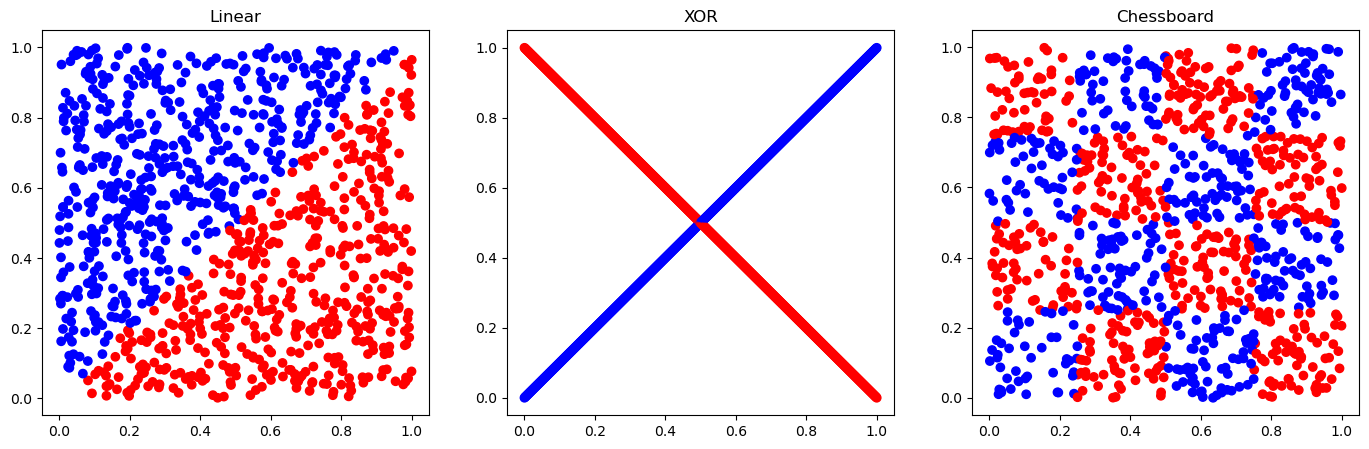

In [74]:
plt.figure(figsize=(17, 5))
for i, name in enumerate(['Linear', 'XOR', 'Chessboard']):
    data, label = GenData.fetch_data(name, 1000)
    plt.subplot(1,3,i+1)
    plt.scatter(data[:, 0], data[:, 1], c=label[:, 0], cmap=plt.cm.bwr)
    plt.title(name)

### Run "Linear"

Epochs    0:	accuracy: 50.600	loss: 0.692
Epochs  100:	accuracy: 50.600	loss: 0.689
Epochs  200:	accuracy: 88.400	loss: 0.682
Epochs  300:	accuracy: 91.800	loss: 0.656
Epochs  400:	accuracy: 91.200	loss: 0.528
Epochs  500:	accuracy: 97.600	loss: 0.225
Epochs  600:	accuracy: 100.000	loss: 0.104
Epochs  700:	accuracy: 100.000	loss: 0.069
Epochs  800:	accuracy: 100.000	loss: 0.053
Epochs  900:	accuracy: 100.000	loss: 0.044
Epochs 1000:	accuracy: 100.000	loss: 0.037
Epochs 1100:	accuracy: 100.000	loss: 0.033
Epochs 1200:	accuracy: 100.000	loss: 0.029
Epochs 1300:	accuracy: 100.000	loss: 0.026
Epochs 1400:	accuracy: 100.000	loss: 0.024
Epochs 1500:	accuracy: 100.000	loss: 0.022
Epochs 1600:	accuracy: 100.000	loss: 0.021
Epochs 1700:	accuracy: 100.000	loss: 0.020
Epochs 1800:	accuracy: 100.000	loss: 0.018
Epochs 1900:	accuracy: 100.000	loss: 0.017

Training complete in 0m 10s
Best test Acc: 100.000000%


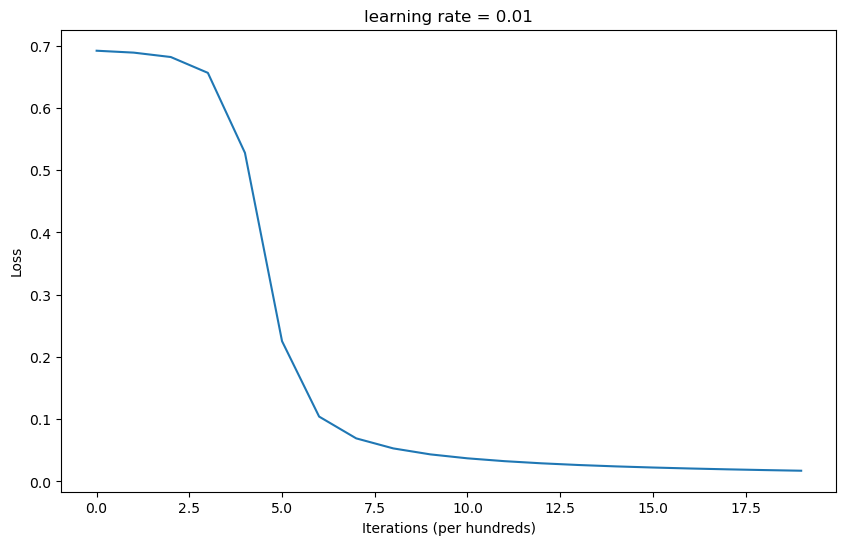

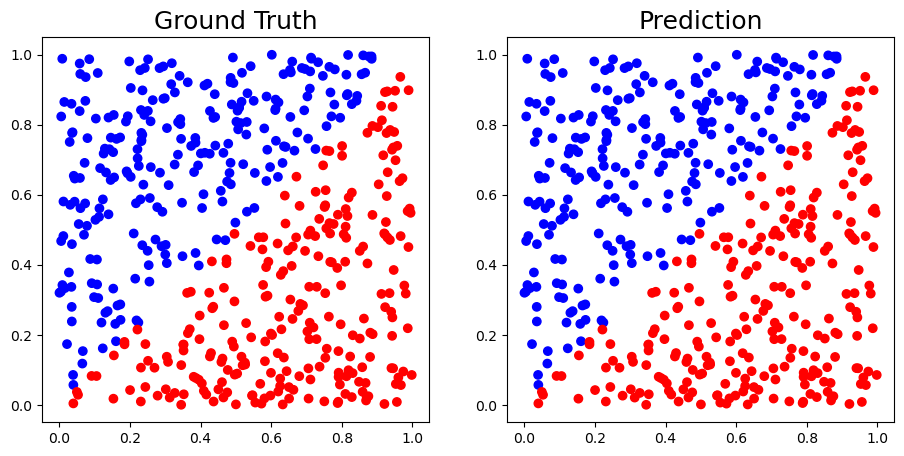

In [75]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Linear", 500)

data = data.T
label = label.reshape(-1, 500)

# epoch         -> 2000
# learning rate -> 0.01
# batch size    -> 100

net = SimpleNet(2000)

parameters = net.train(data, label, batch_size=100)

pred_result = np.round(net.forward(data, parameters)[0])
SimpleNet.plot_result(data, label, pred_result)

### Run "XOR"

Epochs    0:	accuracy: 50.000	loss: 0.693
Epochs  100:	accuracy: 99.600	loss: 0.001
Epochs  200:	accuracy: 99.400	loss: 0.000
Epochs  300:	accuracy: 96.800	loss: 0.000
Epochs  400:	accuracy: 98.000	loss: 0.000
Epochs  500:	accuracy: 98.800	loss: 0.000
Epochs  600:	accuracy: 99.400	loss: 0.000
Epochs  700:	accuracy: 100.000	loss: 0.000
Epochs  800:	accuracy: 97.600	loss: 0.000
Epochs  900:	accuracy: 99.800	loss: 0.000
Epochs 1000:	accuracy: 98.400	loss: 0.000
Epochs 1100:	accuracy: 98.200	loss: 0.000
Epochs 1200:	accuracy: 97.600	loss: 0.000
Epochs 1300:	accuracy: 98.800	loss: 0.000
Epochs 1400:	accuracy: 99.000	loss: 0.000
Epochs 1500:	accuracy: 98.600	loss: 0.000
Epochs 1600:	accuracy: 99.200	loss: 0.000
Epochs 1700:	accuracy: 99.600	loss: 0.000
Epochs 1800:	accuracy: 98.600	loss: 0.000
Epochs 1900:	accuracy: 98.600	loss: 0.000

Training complete in 0m 10s
Best test Acc: 100.000000%


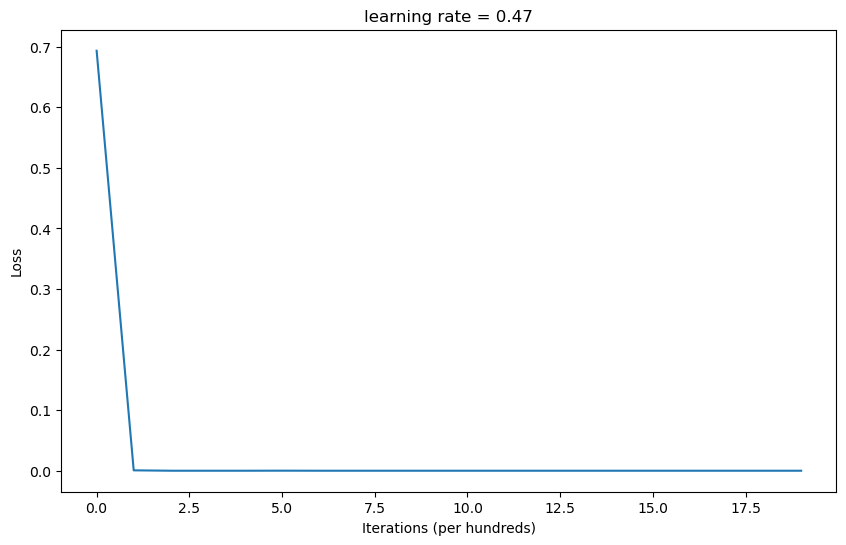

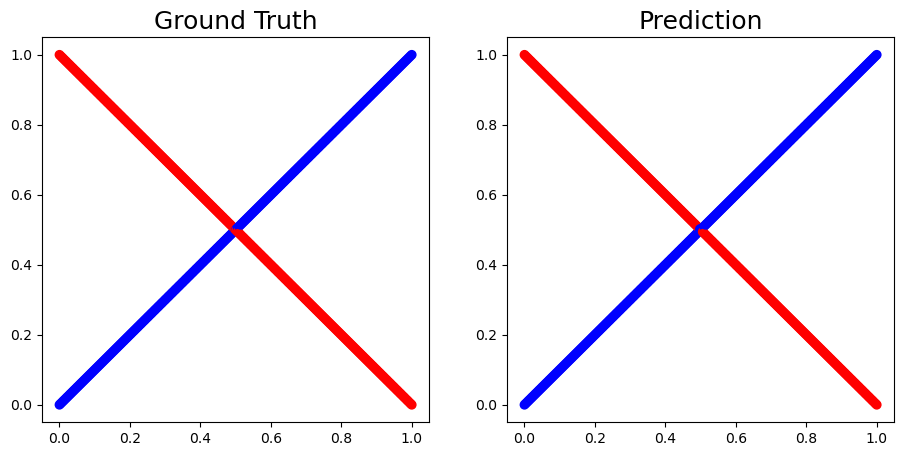

In [77]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("XOR", 500)

data = data.T
label = label.reshape(-1, 500)

# epoch         -> 2000
# learning rate -> 0.47
# batch size    -> 100

net = SimpleNet(2000, learning_rate=0.47)

parameters = net.train(data, label, batch_size=100)

pred_result = np.round(net.forward(data, parameters)[0])
SimpleNet.plot_result(data, label, pred_result)

### Run "Chessboard"

Epochs    0:	accuracy: 51.900	loss: 0.691
Epochs  100:	accuracy: 51.900	loss: 0.689
Epochs  200:	accuracy: 55.900	loss: 0.683
Epochs  300:	accuracy: 51.900	loss: 0.653
Epochs  400:	accuracy: 51.800	loss: 0.645
Epochs  500:	accuracy: 71.500	loss: 0.620
Epochs  600:	accuracy: 77.800	loss: 0.571
Epochs  700:	accuracy: 85.700	loss: 0.411
Epochs  800:	accuracy: 86.300	loss: 0.253
Epochs  900:	accuracy: 89.600	loss: 0.224
Epochs 1000:	accuracy: 92.600	loss: 0.148
Epochs 1100:	accuracy: 94.200	loss: 0.122
Epochs 1200:	accuracy: 95.700	loss: 0.107
Epochs 1300:	accuracy: 95.400	loss: 0.107
Epochs 1400:	accuracy: 97.900	loss: 0.065
Epochs 1500:	accuracy: 95.400	loss: 0.108
Epochs 1600:	accuracy: 95.800	loss: 0.078
Epochs 1700:	accuracy: 96.600	loss: 0.085
Epochs 1800:	accuracy: 96.400	loss: 0.086
Epochs 1900:	accuracy: 98.700	loss: 0.064

Training complete in 0m 20s
Best test Acc: 98.700000%


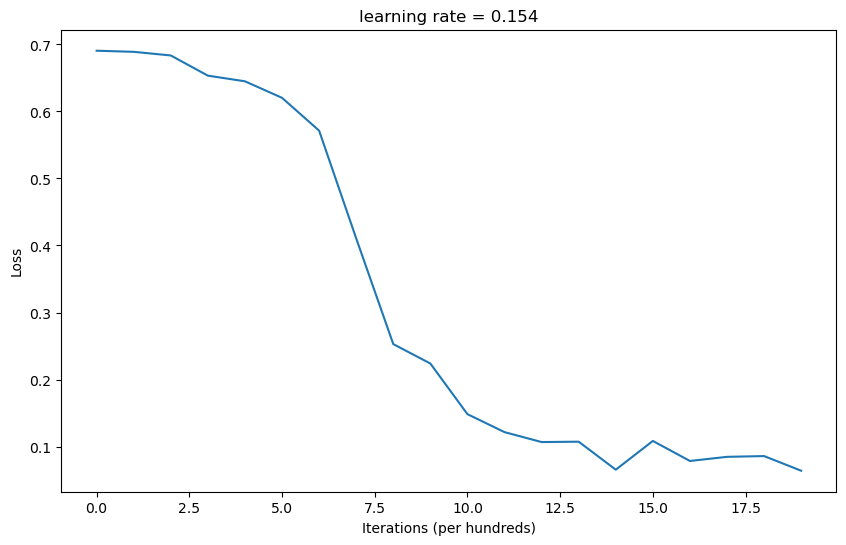

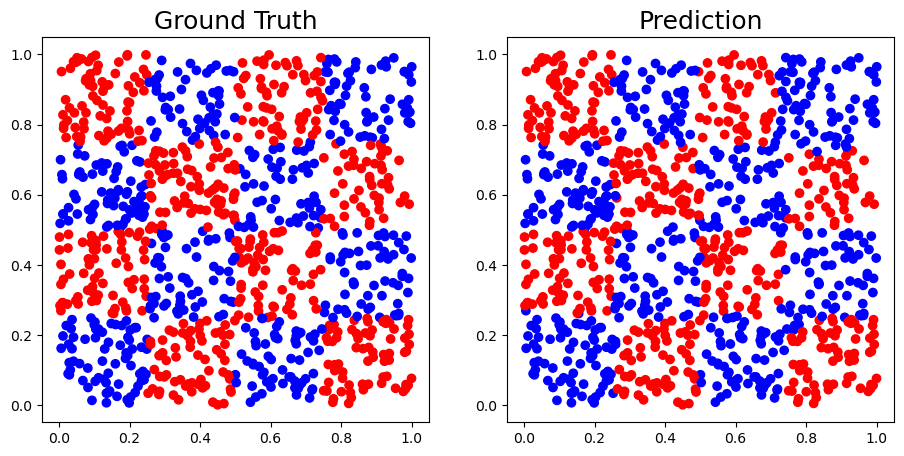

In [78]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)

data = data.T
label = label.reshape(-1, 1000)

# epoch         -> 2000
# learning rate -> 0.154
# batch size    -> 100

net = SimpleNet(2000, learning_rate=0.154)

parameters = net.train(data, label, batch_size=100)

pred_result = np.round(net.forward(data, parameters)[0])
SimpleNet.plot_result(data, label, pred_result)